Backlog prioritization sometimes leads to a difficult choice between two reasonable strategies or simultaneous business processes. Each one has its metrics or composite KPI. If we speak about the product analysis some choices are typical: attraction or conversion rate optimization, attraction or retention, remarketing or audience expansion. Some problems require complex approach – correlations between revenue/transaction frequency and micro KPIs like web conversion are unstable and have low statistical power. In this case machine learning /ML/ techniques may give a value. Predictive power may be used to make a choice in favor of macro strategy. Secondly ML helps to reduce a dimension and simplify KPI – unsupervised learning techniques.  ML scoring is a solution when nonlinearity exists (unit economy equation is nonlinear, conversion depends on acquisition) or distribution of nonsystematic mistakes is far from normal distribution as well. 

Two groups of metrics are considered. First (I) corresponds to web conversion (bounce rate, micro conversion, time). Second (II) corresponds to attraction of new visitors from organic channel (visits, viewers, views). The target function is a number of commercial offers per day converted into the sale. Features and target are normalized to the (0,1) interval. Relatively small data with daily sampling is used – 4 years of recording. Web metrics are parsed from analytical platform through Python API. Sales data is received from local CRM/SQL database – 'offers_cr' target. All offers are started by the call. /Web/=>/Contacts Page/Request Form/Chat/=>/Call/=>/Advisory Department/=>/Sales department/ 

In [441]:
#core#
import numpy as np 
from numpy import linspace, loadtxt, ones, convolve
from numpy import set_printoptions
import pandas as pd 
from pandas import set_option
from operator import add
import dateutil.parser
#/core#

#basic statistical measures#
from statistics import median 
from statistics import mean 
from statistics import stdev
import statsmodels.api as sm
from math import log
#/basic statistical measures#

#charts#
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid
from numpy.polynomial.polynomial import polyfit
#/charts#

#Machine Learning - scikit learn#
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
###
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
#/Machine Learning - scikit learn#

Define custom functions:

In [547]:
def normal(x): #normalize to (0,1) interval
    z=(x-x.min())/(x.max()-x.min())
    return z

def cormap(x): #correlation map
  corr=x.corr();fig=plt.figure(figsize=(10, 7))
  g=sns.heatmap(corr,annot=True,linewidths=.2, cbar_kws={"orientation": "horizontal"})
  plt.show()
    
def get_class(x):
    class_type=[]
    for item in list(x):
        if 0<=item<0.5:   class_type.append(0) #1 class  
        if 0.5<=item<=1:  class_type.append(4) #2 class
    return class_type

def pca(x,y):
  pca=PCA()
  pca.fit(y)
  PCA(copy=True)
  features=x;pca.explained_variance_=normal(pca.explained_variance_)
  pca.explained_variance_=list(np.array(pca.explained_variance_)*100)
  plt.bar(x, pca.explained_variance_,width=0.5);plt.xticks(features);plt.ylabel('variance');plt.xlabel('PCA feature')
  print('\nComponent importance:')
  for i in range(0,len(pca.explained_variance_)):
    print(str(x[i])+': '+str(int(pca.explained_variance_[i]))+'%')
    i=i+1
  plt.show()

Parameters:

In [526]:
split_num=5 #initial number of cross validation folds

Read data from files with crm and web data, parsed by webparse script from web analytics platform API.   

In [527]:
df_web_all=pd.read_excel('DATA_NEW/TRAFFIC.xlsx') #general web sessions/metrics per day
df_web_cr=pd.read_excel('DATA_NEW/WEB_CR.xlsx') #converted web sessions/metrics per day
df_crm=pd.read_excel('DATA_NEW/OFF_CR.xlsx') #crm commercial offers per day

Drop useless columns from df_web_cr and df_web_all

In [528]:
df_web_cr.drop(df_web_cr.columns[2:],axis=1,inplace=True)
df_web_cr['Visits_CR']=df_web_cr['Visits'];del df_web_cr['Visits'];

Merging of dataframes

In [529]:
df=df_web_all.merge(df_web_cr,how='inner',left_on='Date',right_on='Date') #inner join of web metrics and conversion metrics

Add conversion rate column:

In [530]:
df['CR,%']=round(100*df['Visits_CR']/df['Visits']);del df['Visits_CR'] #web conversion
df=df[['Date','Visits','Viewers','Views','BR','Depth','Time','CR,%']] #replace columns
print(df.head())

        Date  Visits  Viewers  Views    BR  Depth    Time   CR,%
0 2015-05-05       8        8     32   0.0    4.0  110.75   50.0
1 2015-05-06       7        7     14   0.0    2.0  101.00   29.0
2 2015-05-07       5        5      8  20.0    1.6   42.80   20.0
3 2015-05-09       1        1      3   0.0    3.0  214.00  100.0
4 2015-05-12       4        4      6   0.0    1.5    9.75   25.0


Merging with crm dataframe - number of commersial offers per day

In [531]:
df=df.merge(df_crm,how='left',left_on='Date',right_on='Date') #inner join with crm data - offers per day and date
df['Offers']=df['Offers'].fillna(0) #fill na with nulls

Show column names, dates, volume

In [532]:
column_names=list(df.columns.values)
print('All fields:',column_names)

print('Data Start:',list(df['Date'])[0])
print('Data End:',list(df['Date'])[-1])

print('Number of records:', len(df))

All fields: ['Date', 'Visits', 'Viewers', 'Views', 'BR', 'Depth', 'Time', 'CR,%', 'Offers']
Data Start: 2015-05-05 00:00:00
Data End: 2019-06-22 00:00:00
Number of records: 1338


Normalize features to the 0,1 interval except date:

In [533]:
date_list=list(df['Date']);del df['Date'] #create date list  

for item in ['Visits','Viewers','Views','BR','Time','CR,%','Offers']: 
    df[item]=normal(df[item])         

Make correlation map:

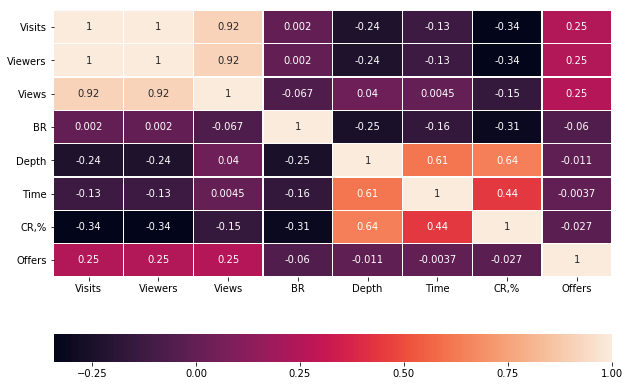

In [534]:
cormap(df)

Viewers and Views are correlated with Visits. This may be used for the dimension reduction. 

In [535]:
description=df['Offers'].describe()
print('Common description:\n')
print(description)

Common description:

count    1338.000000
mean        0.144648
std         0.175323
min         0.000000
25%         0.000000
50%         0.038462
75%         0.269231
max         1.000000
Name: Offers, dtype: float64


Binning of target:

In [548]:
df_binary=df.copy()
df_binary['Offers_BIN']=get_class(df_binary['Offers'])
del df_binary['Offers']

Let's make an estimation of feature importance based on principal component analysis. 


Component importance:
Visits: 100%
Viewers: 91%
Views: 15%
BR: 2%
Depth: 0%
Time: 0%
CR,%: 0%
Offers_BIN: 0%


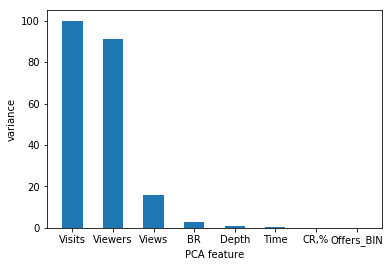

In [549]:
column_names=df_binary.columns
pca(column_names,df_binary)

Visits/Viewers/Views give higher input in scattering of composite KPI according to Principle Component Analysis. It is clear that traffic has higher volatility (seasonality influence). We use ensemble of voting estimators for prediction of target. 

First we use acquisition features: Visits,Viewers,Views.  

In [567]:
array=df_binary.values
X=array[:,0:3];Y=array[:,7]

In [568]:
#building the ensemble#
dt=DecisionTreeClassifier(criterion='entropy')
sv=SVC(gamma='auto')
ab=AdaBoostClassifier(n_estimators=100,random_state=7)
gb=GradientBoostingClassifier(n_estimators=100,random_state=7)
mlp=MLPClassifier(activation='relu', hidden_layer_sizes=(5,1), random_state=1, solver='lbfgs')

estimators=[]
estimators.extend([('dt',dt),('sv',sv),('ab',ab),('gb',gb),('mlp',mlp)])
ensemble=VotingClassifier(estimators)
#/building the ensemble#
   
#output of results#
kfold=KFold(n_splits=split_num,random_state=7)
results=cross_val_score(ensemble,X,Y,cv=kfold)

print('\nAverage score:'+str(round(100*median(results)))+str('%'))
print('Standard deviation of score:'+str(round(100*stdev (results)))+str('%'))
#/output of results#


Average score:94.0%
Standard deviation of score:3%


Good accuracy. Let's test the model in relation to cross validation scale stability.

In [569]:
cv_num=[]
score_cv=[]
score_sc=[]
for item in range(3,30):  
    kfold=KFold(n_splits=item,random_state=7)
    cv_scores=list(cross_val_score(ensemble,X,Y,cv=kfold))
    cv_num.append(item) #split number
    score_med=median(cv_scores) #score median
    score_scatter=abs(max(cv_scores)-min(cv_scores))/2
    
    score_cv.append(score_med) 
    score_sc.append(score_scatter) #score scattering
    
    if (item % 2)==0: 
        print('Splits:'+str(item)+' Median: '+str(round(score_med,2)))

Splits:4 Median: 0.94
Splits:6 Median: 0.95
Splits:8 Median: 0.95
Splits:10 Median: 0.96
Splits:12 Median: 0.96
Splits:14 Median: 0.95
Splits:16 Median: 0.96
Splits:18 Median: 0.96
Splits:20 Median: 0.96
Splits:22 Median: 0.96
Splits:24 Median: 0.96
Splits:26 Median: 0.96
Splits:28 Median: 0.96


Stable in relation to the cross validation scale. Stability factor corresponds to the slope of Variation Facror vice Scale. We may built the relation in log-log format.

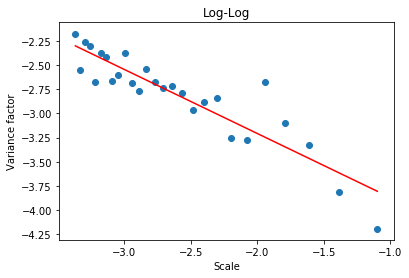

Slope (abs): 0.66
R2: 0.28


In [570]:
var_factor=[log(x/y) for x,y in zip(score_sc,score_cv)]
scale=[log(1/x) for x in cv_num]

plt.scatter(scale,var_factor)
plt.plot(np.unique(scale),np.poly1d(np.polyfit(scale,var_factor,1))(np.unique(scale)),'r')
plt.title('Log-Log')
plt.xlabel('Scale')
plt.ylabel('Variance factor')
plt.show()

R2=round((np.corrcoef(scale,score_cv)[0,1])**2,2)
b,m=polyfit(scale,var_factor,1)
print('Slope (abs):',abs(round(100*m)/100))
print('R2:',R2)

The model is close to overfit area. However, quite stable, because the slope |S|<1 in the power law: VF=const*(Scale^Slope). Now we may test "conversion group" of features. 

In [571]:
array=df_binary.values
X=array[:,3:7];Y=array[:,7]

#output of results#
kfold=KFold(n_splits=split_num,random_state=7)
results=cross_val_score(ensemble,X,Y,cv=kfold)

print('\nAverage score:'+str(round(100*median(results)))+str('%'))
print('Standard deviation of score:'+str(round(100*stdev (results)))+str('%'))
#/output of results#


Average score:94.0%
Standard deviation of score:2%


In [572]:
cv_num=[]
score_cv=[]
score_sc=[]
for item in range(3,30):  
    kfold=KFold(n_splits=item,random_state=7)
    cv_scores=list(cross_val_score(ensemble,X,Y,cv=kfold))
    cv_num.append(item) #split number
    score_med=median(cv_scores) #score median
    score_scatter=abs(max(cv_scores)-min(cv_scores))/2
    
    score_cv.append(score_med) 
    score_sc.append(score_scatter) #score scattering
    
    if (item % 2)==0: 
        print('Splits:'+str(item)+' Median: '+str(round(score_med,2)))

Splits:4 Median: 0.94
Splits:6 Median: 0.96
Splits:8 Median: 0.96
Splits:10 Median: 0.96
Splits:12 Median: 0.96
Splits:14 Median: 0.96
Splits:16 Median: 0.96
Splits:18 Median: 0.96
Splits:20 Median: 0.98
Splits:22 Median: 0.96
Splits:24 Median: 0.96
Splits:26 Median: 0.96
Splits:28 Median: 0.97


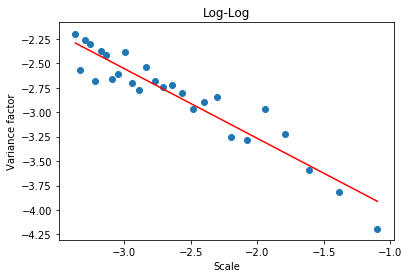

Slope (abs): 0.71
R2: 0.31


In [573]:
var_factor=[log(x/y) for x,y in zip(score_sc,score_cv)]
scale=[log(1/x) for x in cv_num]

plt.scatter(scale,var_factor)
plt.plot(np.unique(scale),np.poly1d(np.polyfit(scale,var_factor,1))(np.unique(scale)),'r')
plt.title('Log-Log')
plt.xlabel('Scale')
plt.ylabel('Variance factor')
plt.show()

R2=round((np.corrcoef(scale,score_cv)[0,1])**2,2)
b,m=polyfit(scale,var_factor,1)
print('Slope (abs):',abs(round(100*m)/100))
print('R2:',R2)

Product Owner may take into account Prediction Power, Risks and Budget for any of two strategies. In this very case Conversion Rate Optimization /CRO/ is cheaper than SEO or Ads and has less affect of seasonality. Due to seasonality, CRO is more predictable and the model has the higher stability - lower absolute slope. In this case CRO is preferred until results are updated. The proposed method may be generalized in decision making when nonlinearity and the implicit connections between behavior of user and monetization are inevitable. However more simple instruments are preferable if the funnel is linear, short and simple. Combination of both approaches with intuition may give a confidence when making “expensive” decisions.